(factor_analysis)=
# Factor analysis

:::{post} 19 Mar, 2022
:tags: factor analysis, matrix factorization, PCA 
:category: advanced, how-to
:author: Chris Hartl,  Christopher Krapu, Oriol Abril-Pla
:::

Factor analysis is a widely used probabilistic model for identifying low-rank structure in multivariate data as encoded in latent variables. It is very closely related to principal components analysis, and differs only in the prior distributions assumed for these latent variables. It is also a good example of a linear Gaussian model as it can be described entirely as a linear transformation of underlying Gaussian variates. For a high-level view of how factor analysis relates to other models, you can check out [this diagram](https://www.cs.ubc.ca/~murphyk/Bayes/Figures/gmka.gif) originally published by Ghahramani and Roweis.

:::{include} ../extra_installs.md
:::

In [1]:
import arviz as az
import numpy as np
import pymc as pm
import pytensor.tensor as pt
import scipy as sp
import seaborn as sns
import xarray as xr

from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from numpy.random import default_rng
from xarray_einstats import linalg
from xarray_einstats.stats import XrContinuousRV

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.9.2


In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

np.set_printoptions(precision=3, suppress=True)
RANDOM_SEED = 31415
rng = default_rng(RANDOM_SEED)

## Simulated data generation

To work through a few examples, we'll first generate some data. The data will not follow the exact generative process assumed by the factor analysis model, as the latent variates will not be Gaussian. We'll assume that we have an observed data set with $N$ rows and $d$ columns which are actually a noisy linear function of $k_{true}$ latent variables.

In [3]:
n = 250
k_true = 4
d = 10

The next code cell generates the data via creating latent variable arrays `M` and linear transformation `Q`. Then, the matrix product $QM$ is perturbed with additive Gaussian noise controlled by the variance parameter `err_sd`.

In [4]:
err_sd = 2
M = rng.binomial(1, 0.25, size=(k_true, n))
Q = np.hstack([rng.exponential(2 * k_true - k, size=(d, 1)) for k in range(k_true)]) * rng.binomial(
    1, 0.75, size=(d, k_true)
)
Y = np.round(1000 * np.dot(Q, M) + rng.standard_normal(size=(d, n)) * err_sd) / 1000

Because of the way we have generated the data, the covariance matrix expressing correlations between columns of $Y$ will be equal to $QQ^T$. The fundamental assumption of PCA and factor analysis is that $QQ^T$ is not full rank. We can see hints of this if we plot the covariance matrix:

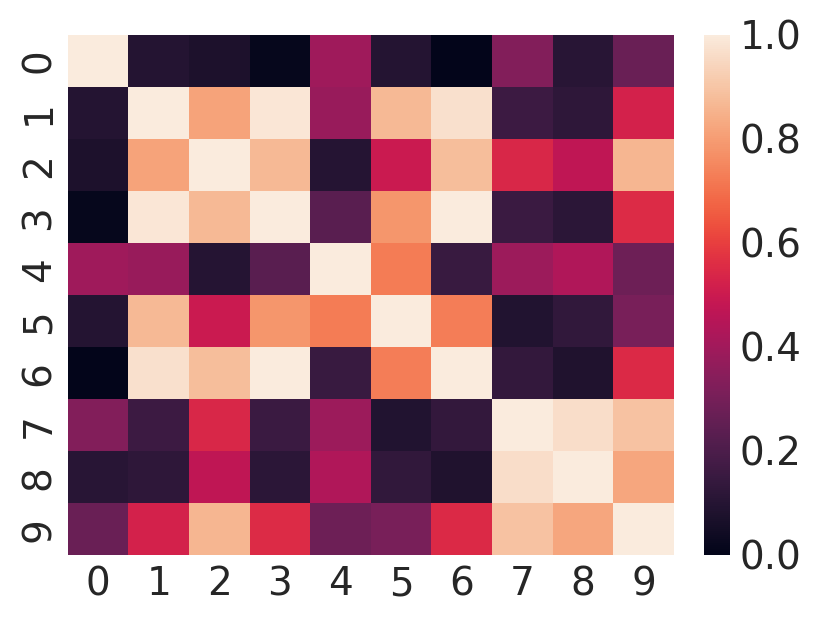

In [5]:
plt.figure(figsize=(4, 3))
sns.heatmap(np.corrcoef(Y));

If you squint long enough, you may be able to glimpse a few places where distinct columns are likely linear functions of each other.

## Model
Probabilistic PCA (PPCA) and factor analysis (FA) are a common source of topics on [PyMC Discourse](https://discourse.pymc.io/). The posts linked below handle different aspects of the problem including:
* [Minibatched FA for large datasets](https://discourse.pymc.io/t/large-scale-factor-analysis-with-minibatch-advi/246)
* [Handling missing data in FA](https://discourse.pymc.io/t/dealing-with-missing-data/252)
* [Identifiability in FA / PPCA](https://discourse.pymc.io/t/unique-solution-for-probabilistic-pca/1324/14)

### Direct implementation

The model for factor analysis is the probabilistic matrix factorization

$X_{(d,n)}|W_{(d,k)}, F_{(k,n)} \sim N(WF, \Psi)$

with $\Psi$ a diagonal matrix. Subscripts denote the dimensionality of the matrices. Probabilistic PCA is a variant that sets $\Psi = \sigma^2I$. A basic implementation (taken from [this gist](https://gist.github.com/twiecki/c95578a6539d2098be2d83575e3d15fe)) is shown in the next cell. Unfortunately, it has undesirable properties for model fitting.

In [6]:
k = 2

coords = {"latent_columns": np.arange(k), "rows": np.arange(n), "observed_columns": np.arange(d)}

with pm.Model(coords=coords) as PPCA:
    W = pm.Normal("W", dims=("observed_columns", "latent_columns"))
    F = pm.Normal("F", dims=("latent_columns", "rows"))
    psi = pm.HalfNormal("psi", 1.0)
    X = pm.Normal("X", mu=pt.dot(W, F), sigma=psi, observed=Y, dims=("observed_columns", "rows"))

    trace = pm.sample(tune=2000, random_seed=rng)  # target_accept=0.9

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [W, F, psi]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 51 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.


At this point, there are already several warnings regarding diverging samples and failure of convergence checks. We can see further problems in the trace plot below. This plot shows the path taken by each sampler chain for a single entry in the matrix $W$ as well as the average evaluated over samples for each chain.

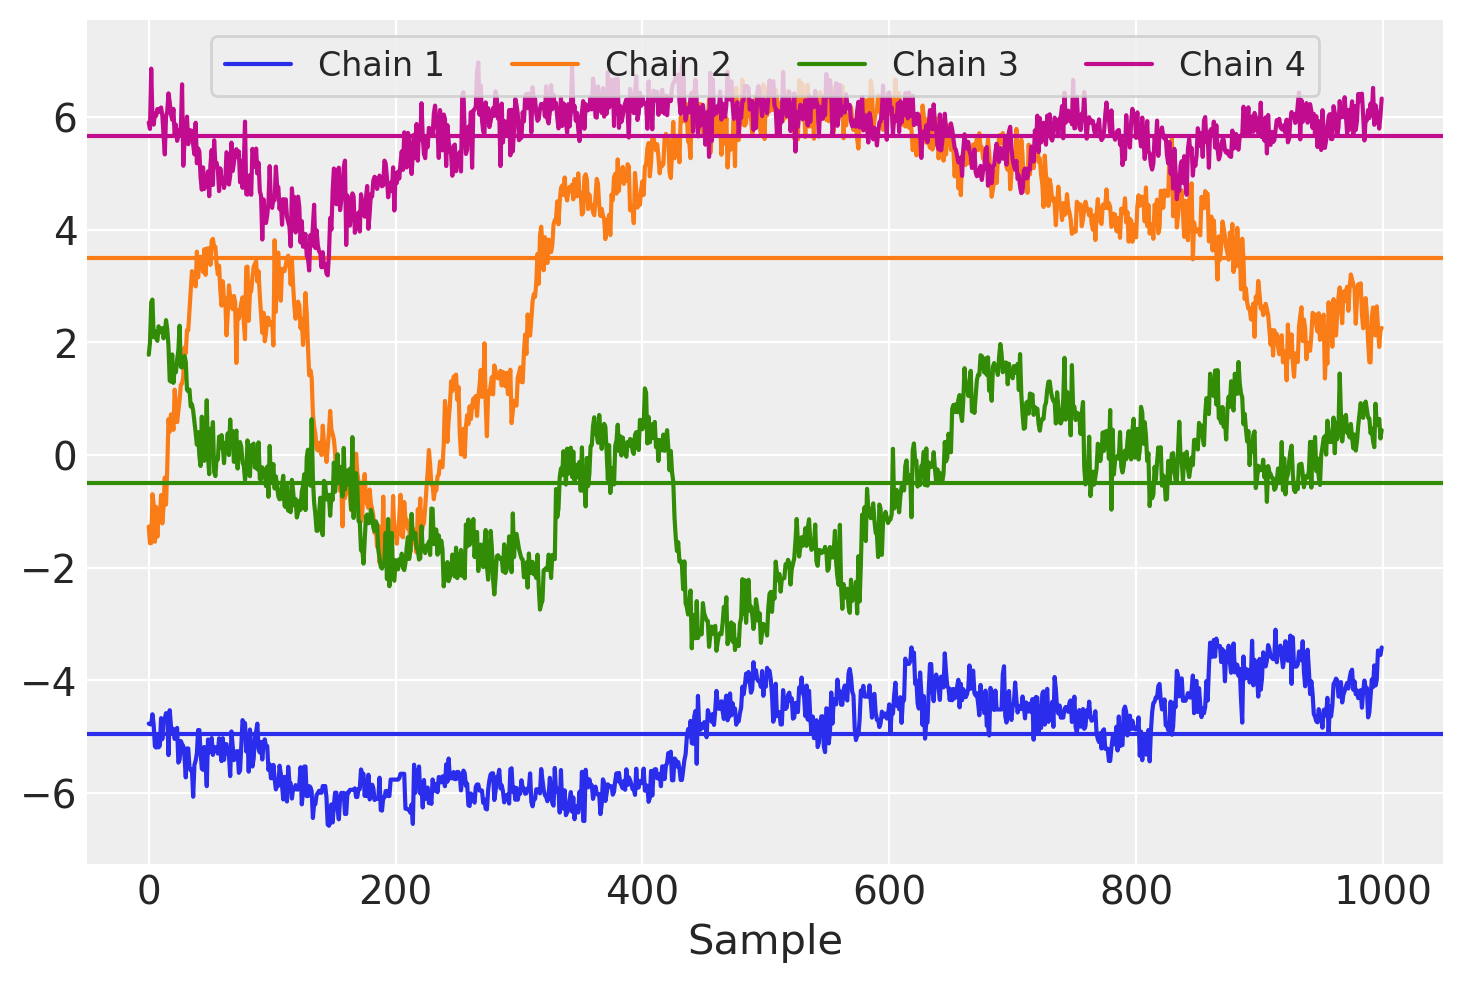

In [7]:
for i in trace.posterior.chain.values:
    samples = trace.posterior["W"].sel(chain=i, observed_columns=3, latent_columns=1)
    plt.plot(samples, label="Chain {}".format(i + 1))
    plt.axhline(samples.mean(), color=f"C{i}")
plt.legend(ncol=4, loc="upper center", fontsize=12, frameon=True), plt.xlabel("Sample");

Each chain appears to have a different sample mean and we can also see that there is a great deal of autocorrelation across chains, manifest as long-range trends over sampling iterations. Some of the chains may have divergences as well, lending further evidence to the claim that using MCMC for this model as shown is suboptimal.

One of the primary drawbacks for this model formulation is its lack of identifiability. With this model representation, only the product $WF$ matters for the likelihood of $X$, so $P(X|W, F) = P(X|W\Omega, \Omega^{-1}F)$ for any invertible matrix $\Omega$. While the priors on $W$ and $F$ constrain $|\Omega|$ to be neither too large or too small, factors and loadings can still be rotated, reflected, and/or permuted *without changing the model likelihood*. Expect it to happen between runs of the sampler, or even for the parametrization to "drift" within run, and to produce the highly autocorrelated $W$ traceplot above.

### Alternative parametrization

This can be fixed by constraining the form of W to be:
  + Lower triangular
  + Positive with an increasing diagonal

We can adapt `expand_block_triangular` to fill out a non-square matrix. This function mimics `pm.expand_packed_triangular`, but while the latter only works on packed versions of square matrices (i.e. $d=k$ in our model, the former can also be used with nonsquare matrices.

In [8]:
def expand_packed_block_triangular(d, k, packed, diag=None, mtype="pytensor"):
    # like expand_packed_triangular, but with d > k.
    assert mtype in {"pytensor", "numpy"}
    assert d >= k

    def set_(M, i_, v_):
        if mtype == "pytensor":
            return pt.set_subtensor(M[i_], v_)
        M[i_] = v_
        return M

    out = pt.zeros((d, k), dtype=float) if mtype == "pytensor" else np.zeros((d, k), dtype=float)
    if diag is None:
        idxs = np.tril_indices(d, m=k)
        out = set_(out, idxs, packed)
    else:
        idxs = np.tril_indices(d, k=-1, m=k)
        out = set_(out, idxs, packed)
        idxs = (np.arange(k), np.arange(k))
        out = set_(out, idxs, diag)
    return out

We'll also define another function which helps create a diagonal positive matrix with increasing entries along the main diagonal.

In [9]:
def makeW(d, k, dim_names):
    # make a W matrix adapted to the data shape
    n_od = int(k * d - k * (k - 1) / 2 - k)

    # trick: the cumulative sum of z will be positive increasing
    z = pm.HalfNormal("W_z", 1.0, dims="latent_columns")
    b = pm.HalfNormal("W_b", 1.0, shape=(n_od,), dims="packed_dim")
    L = expand_packed_block_triangular(d, k, b, pt.ones(k))
    W = pm.Deterministic("W", pt.dot(L, pt.diag(pt.extra_ops.cumsum(z))), dims=dim_names)
    return W

With these modifications, we remake the model and run the MCMC sampler again.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [W_z, W_b, F, psi]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 55 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


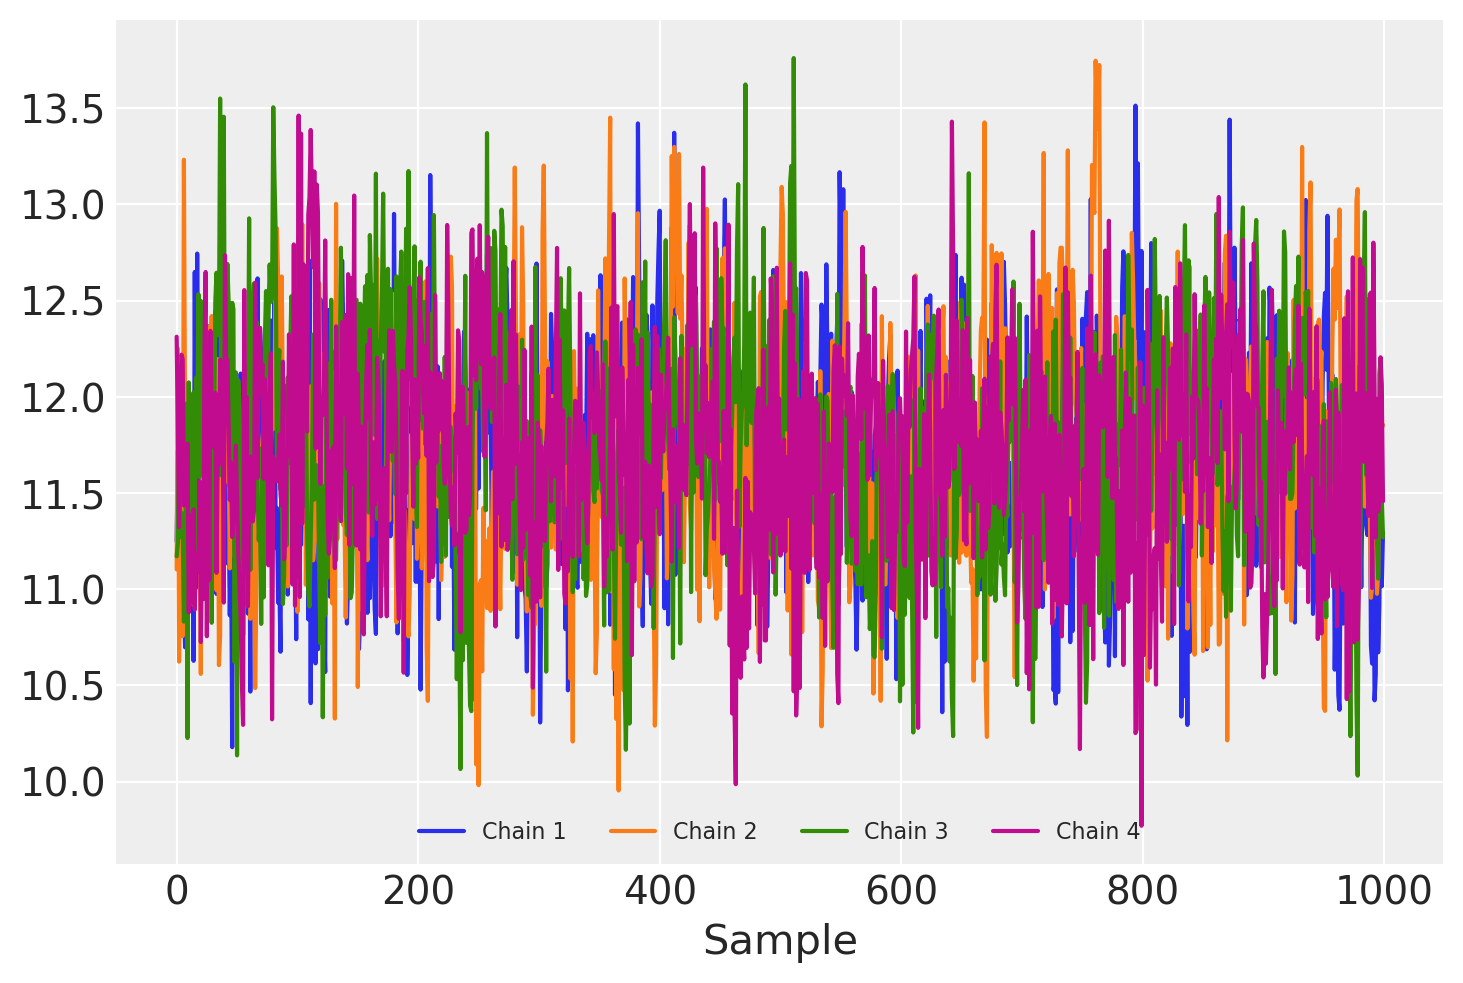

In [10]:
with pm.Model(coords=coords) as PPCA_identified:
    W = makeW(d, k, ("observed_columns", "latent_columns"))
    F = pm.Normal("F", dims=("latent_columns", "rows"))
    psi = pm.HalfNormal("psi", 1.0)
    X = pm.Normal("X", mu=pt.dot(W, F), sigma=psi, observed=Y, dims=("observed_columns", "rows"))
    trace = pm.sample(tune=2000, random_seed=rng)  # target_accept=0.9

for i in range(4):
    samples = trace.posterior["W"].sel(chain=i, observed_columns=3, latent_columns=1)
    plt.plot(samples, label="Chain {}".format(i + 1))

plt.legend(ncol=4, loc="lower center", fontsize=8), plt.xlabel("Sample");

$W$ (and $F$!) now have entries with identical posterior distributions as compared between sampler chains.

Because the $k \times n$ parameters in F all need to be sampled, sampling can become quite expensive for very large `n`. In addition, the link between an observed data point $X_i$ and an associated latent value $F_i$ means that streaming inference with mini-batching cannot be performed.

This scalability problem can be addressed analytically by integrating $F$ out of the model. By doing so, we postpone any calculation for individual values of $F_i$ until later. Hence, this approach is often described as *amortized inference*. However, this fixes the prior on $F$, allowing for less modeling flexibility. In keeping with $F_{ij} \sim \mathcal{N(0, 1)}$ we have:

$X|WF \sim \mathcal{N}(WF, \Psi^2), \;\; F_{ij} \sim N(0, 1)$

$X|W \sim \mathcal{N}(0, \Psi^2 + WW^T)$

If you are unfamiliar with the matrix normal distribution, you can consider it to be an extension of the multivariate Gaussian to matrix-valued random variates. Then, the between-row correlations and the between-column correlations are handled by two separate covariance matrices specified as parameters to the matrix normal. Here, it simplifies our notation for a model formulation that has marginalized out $F_i$. The explicit integration of $F_i$ also enables batching the observations for faster computation of `ADVI` and `FullRankADVI` approximations.

In [11]:
coords["observed_columns2"] = coords["observed_columns"]
with pm.Model(coords=coords) as PPCA_scaling:
    W = makeW(d, k, ("observed_columns", "latent_columns"))
    Y_mb = pm.Minibatch(
        Y.T, batch_size=50
    )  # MvNormal parametrizes covariance of columns, so transpose Y
    psi = pm.HalfNormal("psi", 1.0)
    E = pm.Deterministic(
        "cov",
        pt.dot(W, pt.transpose(W)) + psi**2 * pt.diag(pt.ones(d)),
        dims=("observed_columns", "observed_columns2"),
    )
    X = pm.MvNormal("X", 0.0, cov=E, observed=Y_mb)
    trace_vi = pm.fit(n=50000, method="fullrank_advi", obj_n_mc=1).sample()

Finished [100%]: Average Loss = 1,747.3
/home/erik/mambaforge/envs/pymc_examples/lib/python3.11/site-packages/pymc/backends/arviz.py:65: UserWarning: Could not extract data from symbolic observation X
  warnings.warn(f"Could not extract data from symbolic observation {obs}")


## Results
When we compare the posteriors calculated using MCMC and VI, we find that (for at least this specific parameter we are looking at) the two distributions are close, but they do differ in their mean. The MCMC chains all agree with each other and the ADVI estimate is not far off.

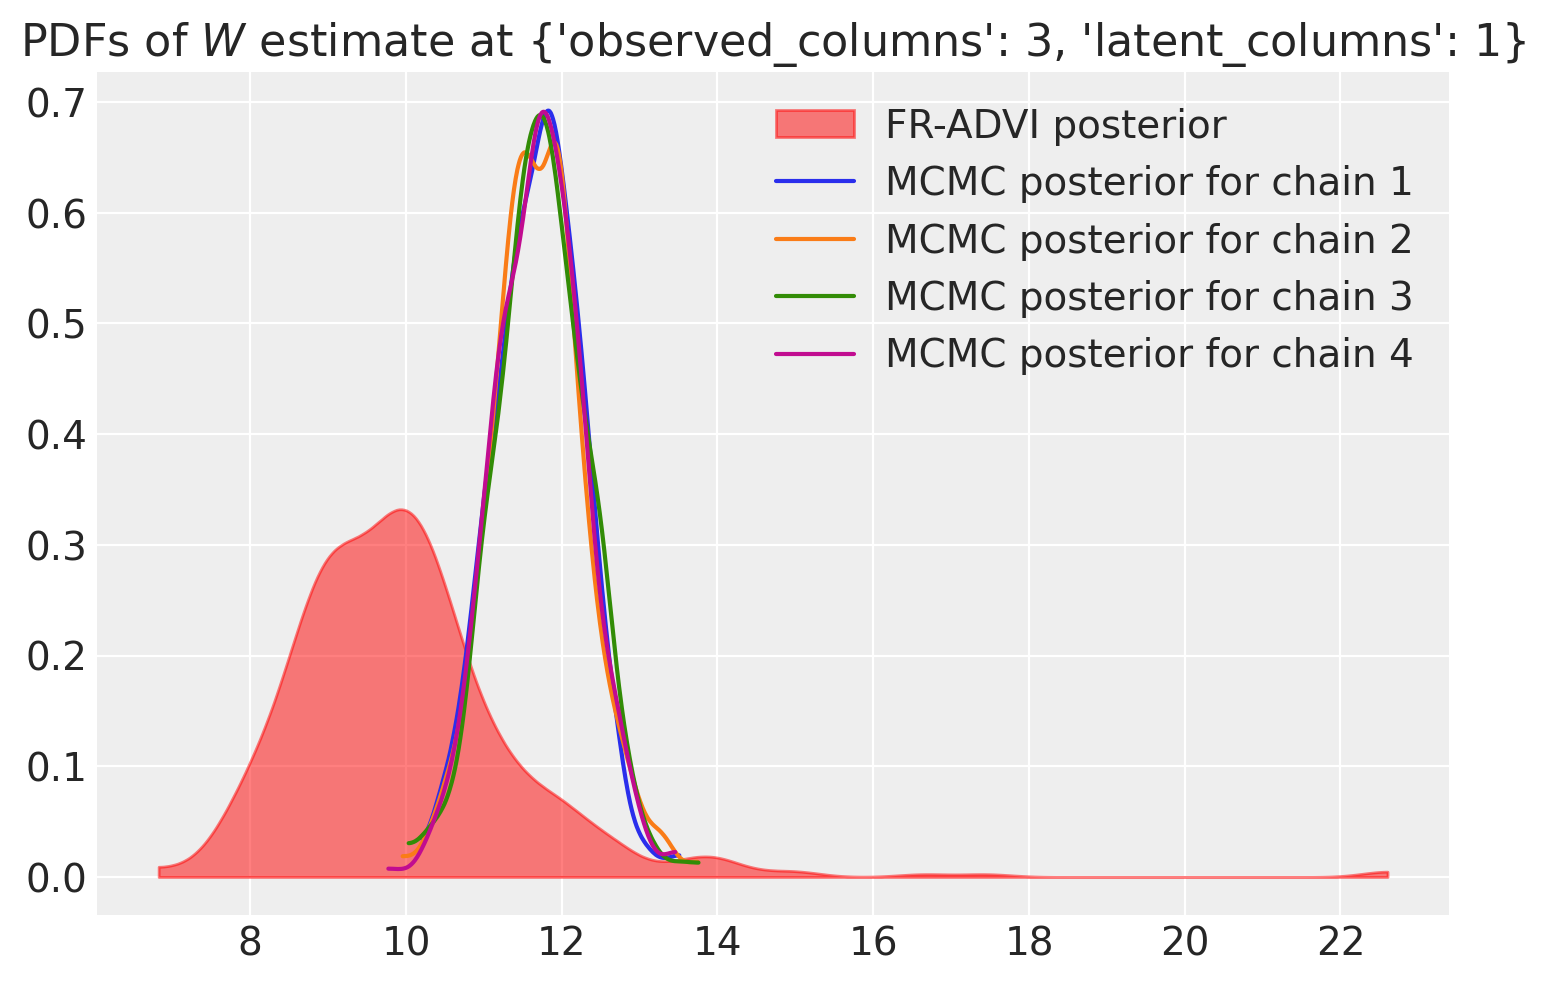

In [12]:
col_selection = dict(observed_columns=3, latent_columns=1)
ax = az.plot_kde(
    trace_vi.posterior["W"].sel(**col_selection).squeeze().values,
    label="FR-ADVI posterior",
    plot_kwargs={"alpha": 0},
    fill_kwargs={"alpha": 0.5, "color": "red"},
)
for i in trace.posterior.chain.values:
    mcmc_samples = trace.posterior["W"].sel(chain=i, **col_selection).values
    az.plot_kde(
        mcmc_samples,
        label="MCMC posterior for chain {}".format(i + 1),
        plot_kwargs={"color": f"C{i}"},
    )

ax.set_title(rf"PDFs of $W$ estimate at {col_selection}")
ax.legend(loc="upper right");

### Post-hoc identification of F

The matrix $F$ is typically of interest for factor analysis, and is often used as a feature matrix for dimensionality reduction. However, $F$ has been
marginalized away in order to make fitting the model easier; and now we need it back. This is, in effect, an exercise in least-squares as:

$X|WF \sim \mathcal{N}(WF, \Psi^2)$

$(W^TW)^{-1}W^T X|W,F \sim \mathcal{N}(F, \Psi^2(W^TW)^{-1})$

Here, we draw many random variates from a standard normal distribution, transforming them appropriate to represent the posterior of $F$ which is multivariate normal under our model.

In [13]:
# configure xarray-einstats
def get_default_dims(dims, dims2):
    proposed_dims = [dim for dim in dims if dim not in {"chain", "draw"}]
    assert len(proposed_dims) == 2
    if dims2 is None:
        return proposed_dims


linalg.get_default_dims = get_default_dims

In [14]:
post = trace_vi.posterior
obs = trace.observed_data

WW_inv = linalg.inv(
    linalg.matmul(
        post["W"], post["W"], dims=("latent_columns", "observed_columns", "latent_columns")
    )
)
WW_W = linalg.matmul(
    WW_inv,
    post["W"],
    dims=(("latent_columns", "latent_columns2"), ("latent_columns", "observed_columns")),
)
F_mu = xr.dot(WW_W, obs["X"], dims="observed_columns")
WW_chol = linalg.cholesky(WW_inv)
norm_dist = XrContinuousRV(sp.stats.norm, xr.zeros_like(F_mu))  # the zeros_like defines the shape
F_sampled = F_mu + linalg.matmul(
    post["psi"] * WW_chol,
    norm_dist.rvs(),
    dims=(("latent_columns", "latent_columns2"), ("latent_columns", "rows")),
)

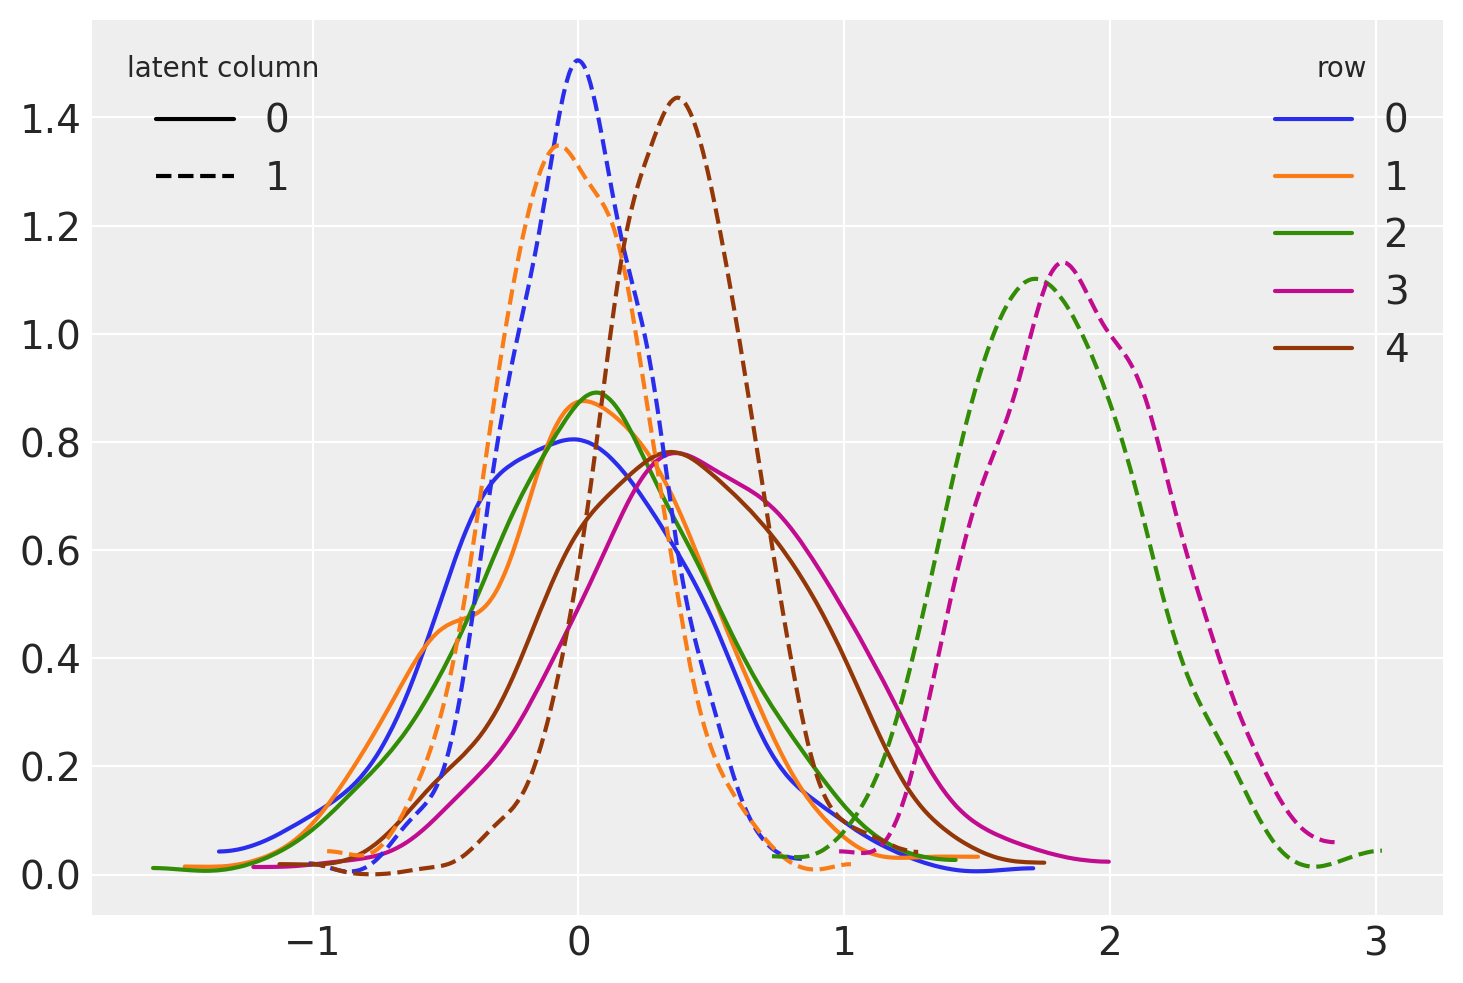

In [15]:
fig, ax = plt.subplots()
ls = ["-", "--"]
for i in range(2):
    for j in range(5):
        az.plot_kde(
            F_sampled.sel(latent_columns=i, rows=j).squeeze().values,
            plot_kwargs={"color": f"C{j}", "ls": ls[i]},
            ax=ax,
        )
legend = ax.legend(
    handles=[Line2D([], [], color="k", ls=ls[i], label=f"{i}") for i in range(2)],
    title="latent column",
    loc="upper left",
)
ax.add_artist(legend)
ax.legend(
    handles=[Line2D([], [], color=f"C{i}", label=f"{i}") for i in range(5)],
    title="row",
    loc="upper right",
);

## Authors
* Authored by [chartl](https://github.com/chartl) on May 6, 2019
* Updated by [Christopher Krapu](https://github.com/ckrapu) on April 4, 2021
* Updated by Oriol Abril-Pla to use PyMC v4 and xarray-einstats on March, 2022

## Watermark

In [16]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Thu Nov 16 2023

Python implementation: CPython
Python version       : 3.11.6
IPython version      : 8.16.1

numpy          : 1.25.2
pytensor       : 2.17.3
scipy          : 1.11.3
matplotlib     : 3.8.1
xarray_einstats: 0.6.0
seaborn        : 0.13.0
arviz          : 0.16.1
pymc           : 5.9.2
xarray         : 2023.10.1

Watermark: 2.4.3



:::{include} ../page_footer.md
:::